# 03 - web scraping and data transformations

1. [The TSA posts passenger numbers](https://www.tsa.gov/coronavirus/passenger-throughput) in a table but there is no download or API option. We can use BeautifulSoup to parse this table.
1. Transform the TSA passenger data in two ways to create two different charts
1. Create two charts inside this notebook with [Matplotlib](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

__Library reference__
- [BeautifulSoup]()
- [pandas]()
- [Matplot for pandas]()
- [Datetime format codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes)

1. Turn the TSA's html table into a dataframe
    1. Create a list of column names
    1. Create a 2d array of data
    1. Format the data into two columns: date and value
1. Transform the data in two different ways for new different charts
1. Create two charts

In [104]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [88]:
#### Import libraries
import pandas as pd
import requests
from datetime import datetime


## 1. Turn the TSA's html table into a dataframe

In [89]:
link = 'https://www.tsa.gov/coronavirus/passenger-throughput'

headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
    'Accept': '*/*',
    'Accept-Language': 'pt-BR,pt;q=0.8,en-US;q=0.5,en;q=0.3',
    'Content-Type': 'text/plain',
    'Origin': 'https://www.tsa.gov',
    'Connection': 'keep-alive',
    'Referer': 'https://www.tsa.gov/',
    'Cache-Control': 'max-age=0',
    'TE': 'Trailers',
}

response = requests.get(link, headers=headers)

table = pd.read_html(response.content)[0]

df = pd.DataFrame(table)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      365 non-null    object 
 1   2021 Traveler Throughput  192 non-null    float64
 2   2020 Traveler Throughput  365 non-null    int64  
 3   2019 Traveler Throughput  365 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 11.5+ KB


In [90]:
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = pd.to_datetime(df['Date']).dt.month
df['day'] = pd.to_datetime(df['Date']).dt.day

df.head()

,Date,2021 Traveler Throughput,2020 Traveler Throughput,2019 Traveler Throughput,month,day
0,2021-07-11,2198635.0,754545,2669717,7,11
1,2021-07-10,1987652.0,656284,2312178,7,10
2,2021-07-09,2147903.0,711124,2716812,7,9
3,2021-07-08,2027364.0,709653,2608209,7,8
4,2021-07-07,1880160.0,632498,2515902,7,7


In [91]:
colnames = ['old_date','2021','2020','2019','month','day']

df.columns = colnames

df = pd.melt(df,id_vars=['old_date','day','month'],var_name='year', value_name='values')

df.head()

,old_date,day,month,year,values
0,2021-07-11,11,7,2021,2198635.0
1,2021-07-10,10,7,2021,1987652.0
2,2021-07-09,9,7,2021,2147903.0
3,2021-07-08,8,7,2021,2027364.0
4,2021-07-07,7,7,2021,1880160.0


In [92]:
df['date'] = df['day'].astype(str) + '/' + df['month'].astype(str) + '/' + df['year'].astype(str)
df['date'] = pd.to_datetime(df['date'])



,date,values
0,2021-11-07,2198635.0
1,2021-10-07,1987652.0
2,2021-09-07,2147903.0
3,2021-08-07,2027364.0
4,2021-07-07,1880160.0


In [98]:
# turn passengers_per_day into a DataFrame with "date" "value" columns
df = df[['date','values']]



# delete duplicates
df[df.duplicated()]

,date,values


In [114]:
# sort dates from latest to earliest
df = df.sort_values('date', ascending=True)

## 2. Transform the data in two different ways for two different charts
[What's moving average and why are they used? - Dallas FED](https://www.dallasfed.org/research/basics/moving.aspx)

### a. Calculate 7-day moving average

In [102]:
# display the last 7 rows
df.tail(7)

,date,values
1088,2019-07-18,2396462.0
1089,2019-07-17,2776960.0
1090,2019-07-16,2716828.0
1091,2019-07-15,2522563.0
1092,2019-07-14,2447177.0
1093,2019-07-13,2615115.0
1094,2019-12-07,2669717.0


In [143]:
# write a function that takes the current date and 6 previous dates and averages them
df['mv_avg'] = df['values'].rolling(window=7).mean()
df = df.dropna()

df

<ipython-input-143-3b45981cfa82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mv_avg'] = df['values'].rolling(window=7).mean()


,date,values,mv_avg
909,2019-01-13,1970450.000,2236077.429
908,2019-01-14,1886642.000,2207203.429
907,2019-01-15,1605758.000,2098316.429
906,2019-01-16,1786012.000,2062353.857
905,2019-01-17,2139242.000,2018290.286
...,...,...,...
4,2021-07-07,1880160.000,1363955.571
3,2021-08-07,2027364.000,1543331.286
2,2021-09-07,2147903.000,1728083.714
1,2021-10-07,1987652.000,1829383.000


### b. Group data by weeks

In [134]:
df_week = df.groupby([pd.Grouper(key='date', freq='W-MON')])['values'].sum().reset_index().sort_values('date')
df_week

,date,values
0,2019-01-07,2088760.000
1,2019-01-14,15450424.000
2,2019-01-21,13358409.000
3,2019-01-28,13056526.000
4,2019-02-04,13460036.000
...,...,...
144,2021-10-11,1987652.000
145,2021-10-18,0.000
146,2021-10-25,0.000
147,2021-11-01,0.000


## 3. Create two charts - one for 7-day moving average and one for week totals
Create a bar chart of the daily values for reference

<AxesSubplot:xlabel='date'>

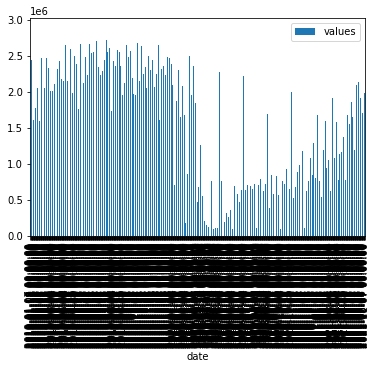

In [141]:
# create a bar chart for daily values

df[['date','values']].plot(y='values',x='date',kind='bar')

<AxesSubplot:xlabel='date'>

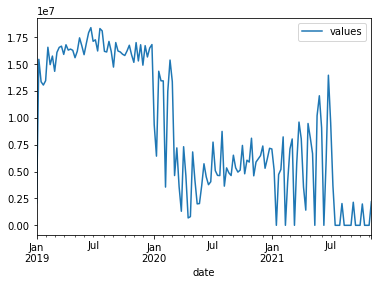

In [136]:
# plot a 7-day average line chart
df_week[['date','values']].plot(y='values',x='date')


### b. By weekly totals

<AxesSubplot:xlabel='date'>

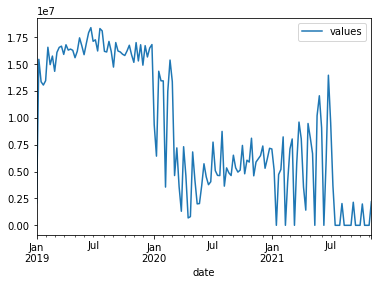

In [142]:
# plot as weeks as a line chart

df_week.plot(x='date',y='values')